In [ ]:
from pathlib import Path
import yaml
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, unix_timestamp, datediff, lit, udf
from pyspark.sql.types import DateType, DoubleType, ArrayType
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from sklearn.utils.class_weight import compute_class_weight

# Loan Default Classification

## Load Data

In [2]:
spark = SparkSession.builder.appName("Loan Default Analysis").getOrCreate()


with open("config.yaml") as f:
    config = yaml.safe_load(f)
data_path = config["raw_data_path"] + "loan_default.csv"


df = spark.read.csv(data_path, header=True, inferSchema=True)

25/07/10 15:12:21 WARN Utils: Your hostname, Hyle resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/07/10 15:12:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/10 15:12:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

## Data Preprocessing


### Check missing values

In [3]:
total_count = df.count()


# Check null count of columns with >10% missing values
for c in df.columns:
    null_count = df.filter(col(c).isNull()).count()
    null_percentage = (null_count / total_count) * 100
    
    if null_percentage > 5:
        print(f"{c}: {null_count} nulls ({null_percentage:.2f}%)")

emp_title: 49439 nulls (5.78%)
desc: 734155 nulls (85.77%)
mths_since_last_delinq: 439669 nulls (51.37%)
mths_since_last_record: 724613 nulls (84.65%)
next_pymnt_d: 252751 nulls (29.53%)
mths_since_last_major_derog: 642637 nulls (75.08%)
annual_inc_joint: 855343 nulls (99.93%)
dti_joint: 855382 nulls (99.93%)
verification_status_joint: 855418 nulls (99.94%)
tot_coll_amt: 67198 nulls (7.85%)
tot_cur_bal: 67224 nulls (7.85%)
open_acc_6m: 842600 nulls (98.44%)
open_il_6m: 842616 nulls (98.44%)
open_il_12m: 842638 nulls (98.44%)
open_il_24m: 842647 nulls (98.44%)
mths_since_rcnt_il: 843010 nulls (98.49%)
total_bal_il: 842655 nulls (98.44%)
il_util: 844337 nulls (98.64%)
open_rv_12m: 842670 nulls (98.45%)
open_rv_24m: 842664 nulls (98.45%)
max_bal_bc: 842668 nulls (98.45%)
all_util: 842675 nulls (98.45%)
total_rev_hi_lim: 67311 nulls (7.86%)
inq_fi: 842676 nulls (98.45%)
total_cu_tl: 842672 nulls (98.45%)
inq_last_12m: 842680 nulls (98.45%)


The dataset is generally high quality, with most core financial and loan-related variables, such as `loan_amnt`, `dti`, `purpose`, and `default_ind` have complete or nearly complete data. A few optional fields like `emp_title` and `next_pymnt_d` show moderate missing values issue, likely due to their context-specific nature (e.g., next payment dates not applicable for closed loans).

In contrast, joint applications variables (e.g., `annual_inc_joint`, `dti_joint`) and severe credit issues (`mths_since_last_major_derog`, `open_il_6m`) have over 90% missing values, reflecting either the rarity of such cases or the limited reporting across borrowers. These patterns suggest that the absence of data is largely structural and not due to random data loss. This pattern is reasonable since qualified borrowers would be very unlikely to exhibit delinquency if the lender's screening processes are appropriate.  

Overall, the dataset is well-structured, with missing values concentrated in specialised fields that may not significantly contribution to predictive analysis.

### Initial statistics of the dataset


In [4]:
# Create a filter for numerical columns from the datast
float_col = [item[0] for item in df.dtypes if item[1].startswith('double')]
int_col = [item[0] for item in df.dtypes if item[1].startswith('int')]
columns_filter = float_col + int_col

# Remove 'id' columns since they don't contribute to predicitons
columns_filter.remove('id')
columns_filter.remove('member_id')

# Apply a filter to calculate summary statistics for the numerical columns
numerical_df = df.select(columns_filter)
summary_stats = numerical_df.describe()
summary_stats.show()

25/07/10 15:12:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+
|summary|   funded_amnt_inv|          int_rate|      installment|         loan_amnt|       funded_amnt|      inq_last_12m|        default_ind|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+
|  count|            855969|            855969|           855969|            855969|            855969|             13289|             855746|
|   mean|14700.061225999756|13.192319605031136|436.2380718343754|14745.571334943204|14732.378304588134|1.8418240650161788|0.05426376518265934|
| stddev| 8425.805478470194| 4.368365181701456|243.7268761679839| 8425.340005005297| 8419.471653319759| 2.974979879227413|0.22653756629105123|
|    min|               0.0|              5.32|            15.69|               500|               500|                -4|                  0|

From the statistic table, we can see some of the characteristics of this specific dataset:

*   Large sample size: The dataset includes over 855,000 records, providing a strong foundation for modeling. The richness of the data suggests good coverage across various borrower profiles

*   Numerical Columns Show Wide Ranges: loan_amnt, annual_inc, and related financial columns have wide value ranges, with some extremely high values (outliers).

*   The standard deviations are large relative to the means in variables like annual_inc and revol_bal, suggesting high variability in borrower financial situations.

*   Missing Numerical Columns: multiple numerical columns, such as `last_pymnt_amnt`did not display when filtered for numerical values,  suggests inconsistent values.

*   Presence of missing data: Some columns have significantly fewer non-null values (e.g., annual_inc_joint, dti_joint, desc, etc). This indicates that missing data is a factor, particularly in optional or borrower-provided fields.

*   Categorical Variables Are Diverse: features like grade, home_ownership, and term show a structured set of categories that likely vary across borrowers. Meanwhile, others like emp_title and title are free-text and likely contain a large number of unique values.

The summary reflects a dataset that is large, diverse, and rich in financial and behavioral attributes, but it also includes missing values, outliers, and some redundancy.






### Dimensionality Reduction




Due to the complexity and redundancy of many features from the dataset, these columns will be removed:

In [5]:
columns_to_drop = [
    ("id", "Unique identifier with no predictive value"),
    ("member_id", "Same as id; only serves as a borrower reference"),
    ("url", "Link to listing; irrelevant for modeling"),
    ("zip_code", "Truncated location info; unecessary for the model"),
    ("title", "Redundant with purpose; free-text, inconsistent"),
    ("desc", "Free-text; 86% missing; adds noise"),
    ("annual_inc_joint", "99.9% missing; joint applications are rare"),
    ("dti_joint", "99.9% missing; too sparse"),
    ("verification_status_joint", "99.9% missing"),
    ("mths_since_last_record", "85% missing"),
    ("mths_since_last_major_derog", "75% missing; sparse and hard to interpret"),
    ("open_acc_6m → inq_last_12m (13 fields)", "~98% missing; recent credit activity fields are mostly empty"),
    ("emp_title", "Free-text job title; inconsistent and high cardinality (~5.8% missing)"),
    ("policy_code", "Almost constant (usually 1); not informative"),
    ("pymnt_plan", "Almost always \"n\" (no active plans); low variance"),
    ("initial_list_status", "Typically dominated by one category; adds little signal"),
    ("funded_amnt", "Highly correlated with loan_amnt; redundant"),
    ("funded_amnt_inv", "Investor-specific version; redundant"),
    ("out_prncp", "Similar to out_prncp_inv; keep one"),
    ("total_pymnt_inv", "Similar to total_pymnt; choose one"),
    ("recoveries", "Borrowers with non-null recoveries are deemed likely to default, collinear with the target"),
    ("collection_recovery_fee", "Same with recoveries, if post charge-off occurs then borrowers are likely to default"),
    ("collections_12_mths_ex_med", "Almost always 0; not informative"),
    ("acc_now_delinq", "Rarely nonzero; low variance"),
    ("open_acc_6m", "~98% missing; recent credit activity field"),
    ("open_il_6m", "~98% missing; recent credit activity field"),
    ("open_il_12m", "~98% missing; recent credit activity field"),
    ("open_il_24m", "~98% missing; recent credit activity field"),
    ("mths_since_rcnt_il", "~98% missing; hard to impute"),
    ("total_bal_il", "~98% missing; mostly unused"),
    ("il_util", "~98% missing; unreliable credit ratio"),
    ("open_rv_12m", "~98% missing; recent credit activity field"),
    ("open_rv_24m", "~98% missing; recent credit activity field"),
    ("max_bal_bc", "~98% missing; rarely populated"),
    ("all_util", "~98% missing; unreliable credit utilisation"),
    ("inq_fi", "~98% missing; few borrowers triggered this"),
    ("total_cu_tl", "~98% missing; limited financial use"),
    ("inq_last_12m", "~98% missing; redundant with inq_last_6mths"),
    ("mths_since_last_delinq", "60% missing"),
    ("next_pymnt_d", "many rows missing, may affect negatively to the model")
]

print(f"{'Column Name':<30} | Justification")
print("-" * 70)
for c, reason in columns_to_drop:
    print(f"{c:<30} | {reason}")
# Extract only the column names
drop_column_names = [colm[0] for colm in columns_to_drop]
df = df.drop(*drop_column_names)

Column Name                    | Justification
----------------------------------------------------------------------
id                             | Unique identifier with no predictive value
member_id                      | Same as id; only serves as a borrower reference
url                            | Link to listing; irrelevant for modeling
zip_code                       | Truncated location info; unecessary for the model
title                          | Redundant with purpose; free-text, inconsistent
desc                           | Free-text; 86% missing; adds noise
annual_inc_joint               | 99.9% missing; joint applications are rare
dti_joint                      | 99.9% missing; too sparse
verification_status_joint      | 99.9% missing
mths_since_last_record         | 85% missing
mths_since_last_major_derog    | 75% missing; sparse and hard to interpret
open_acc_6m → inq_last_12m (13 fields) | ~98% missing; recent credit activity fields are mostly empty
emp_title      

For features with minor missing rows (less than 100 records or 1% of the dataset) such as `purpose`, `dti`, `inq_last_6mths`, and `default_ind`, we chose to drop the null rows to ensure data integrity while maintaining overall dataset size. These variables are either directly relevant to the modeling process or are critical outcome variables, making imputation less reliable and potentially biased.

For fields with moderate null counts like revol_util or last_credit_pull_d, we opted to impute missing values using reasonable defaults (e.g., median for numerical features or 'Unknown' for dates). This approach preserves data volume while minimising distortion in distribution.

In [6]:
null_summary = [
    ["purpose", 1, "Key categorical feature", "Drop the row (only 1)"],
    ["addr_state", 1, "Categorical location info", "Drop the row (only 1)"],
    ["dti", 1, "Important financial ratio", "Drop the row (only 1)"],
    ["delinq_2yrs", 1, "Low frequency delinquency indicator", "Drop the row (only 1)"],
    ["earliest_cr_line", 1, "Useful for tenure features", "Drop the row (only 1)"],
    ["inq_last_6mths", 1, "Recent inquiries; valuable", "Drop the row (only 1)"],
    ["open_acc", 72, "Active accounts; numeric, small null count", "Drop rows"],
    ["pub_rec", 57, "Low variation + low null count", "Drop rows"],
    ["revol_bal", 47, "Revolving balance; very small number", "Drop rows"],
    ["revol_util", 475, "Credit utilisation; important, nulls are manageable", "Impute (e.g., median)"],
    ["total_acc", 17, "Credit history size", "Drop rows"],
    ["out_prncp_inv", 21, "Investment principal; minor", "Drop rows"],
    ["total_pymnt", 12, "Payment-related; small number", "Drop rows"],
    ["total_rec_prncp", 9, "Received principal", "Drop rows"],
    ["total_rec_int", 3, "Received interest", "Drop rows"],
    ["total_rec_late_fee", 3, "Late fee received", "Drop rows"],
    ["collection_recovery_fee", 5, "Related to above", "Drop rows"],
    ["last_pymnt_d", 8869, "Often missing for recent or closed loans", "Impute 'Unknown'"],
    ["last_pymnt_amnt", 3, "Payment amount", "Drop rows"],
    ["last_credit_pull_d", 102, "Credit check recency", "Impute mode"],
    ["application_type", 57, "Joint vs Individual; very few missing", "Drop rows"],
    ["tot_coll_amt", 67198, "May be relevant", "impute "],
    ["tot_cur_bal", 67224, "May be relevant", "impute"],
    ["total_rev_hi_lim", 67311, "High credit limit", "impute"],
    ["default_ind", 223, "Target variable — cannot be missing", "Drop these rows"],
]
print("{:<25} {:<8} {:<50} {}".format("Column", "Nulls", "Comment", "Action"))
print("-" * 120)
for row in null_summary:
    print("{:<25} {:<8} {:<50} {}".format(row[0], row[1], row[2], row[3]))

Column                    Nulls    Comment                                            Action
------------------------------------------------------------------------------------------------------------------------
purpose                   1        Key categorical feature                            Drop the row (only 1)
addr_state                1        Categorical location info                          Drop the row (only 1)
dti                       1        Important financial ratio                          Drop the row (only 1)
delinq_2yrs               1        Low frequency delinquency indicator                Drop the row (only 1)
earliest_cr_line          1        Useful for tenure features                         Drop the row (only 1)
inq_last_6mths            1        Recent inquiries; valuable                         Drop the row (only 1)
open_acc                  72       Active accounts; numeric, small null count         Drop rows
pub_rec                   57       Low var

In [7]:
# Drop the missing values in columns that have minor absence
df = df.na.drop(subset=[
    "purpose", "addr_state", "dti", "delinq_2yrs", "earliest_cr_line", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc", "out_prncp_inv", "total_pymnt",
    "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "last_pymnt_amnt", "application_type",
    "default_ind"
])

### Convert and Encode Date Features

There are date features that are casted as string type in the dataset. Since we are not certain whether these features have predictive power, we will retain the two features `last_pymnt_d` and `earliest_cr_line` and encode them as string using `unix_timestamp`. We decided to drop `issue_d` and `last_credit_pull_d` as we infer they are metadata of the loan and not directly relevant to the likelihood of defaulting. 

We infer that borrowers with low `last_pymnt_d` and `earliest_cr_line` further in the past are likely to make their loan payments on time. This inference, however, requires further business analysis to validate.

In [8]:
df = df.drop('issue_d', 'last_credit_pull_d')


# Convert string casted date to DateType
df = df.withColumn(
    "earliest_cr_line",
    unix_timestamp(col("earliest_cr_line"), "dd-MM-yyyy").cast('timestamp')
)

df = df.withColumn(
    "last_pymnt_d",
    unix_timestamp(col("last_pymnt_d"), "dd-MM-yyyy").cast('timestamp')
)

df = df.withColumn(
    "earliest_cr_line", col("earliest_cr_line").cast(DateType())
)
df = df.withColumn(
    "last_pymnt_d", col("last_pymnt_d").cast(DateType())

)
df = df.withColumn(
    "earliest_cr_line_int",
    datediff(col("earliest_cr_line"), lit("1970-01-01"))
)
df = df.withColumn(
    "last_pymnt_d_int",
    datediff(col("last_pymnt_d"), lit("1970-01-01"))
)

df = df.drop('earliest_cr_line', 'last_pymnt_d')

### Encoding Categorical Variables

Next, we encode the categorical features using StringIndexer to make the dataset appropriate for networks and other models that cannot parse text data.

There were several numeric features recorded as string/text features, we performed type casting for these features to ensure they are of correct types.

In [9]:
# Declare categorical features to encode
categorical_to_encode = [
    "term", "grade", "sub_grade", "emp_length",
    "home_ownership", "verification_status", "purpose",
    "addr_state", "application_type"
]

string_numeric_cols = [
    "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec",
    "total_acc", "out_prncp_inv", "total_pymnt", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "last_pymnt_amnt", "revol_bal", "earliest_cr_line_int","last_pymnt_d_int"
]

numeric_cols = [
    "loan_amnt", "int_rate", "installment", "revol_util", "tot_coll_amt",
    "tot_cur_bal", "total_rev_hi_lim", "default_ind"
]


 # Fit the indexer on the main dataset and transform the categories in the split
for col_name in categorical_to_encode:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    df = indexer.fit(df).transform(df)

# Cast string numeric to DoubleType
for col_name in string_numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))


# Include string numeric columns
numeric_cols += string_numeric_cols

# Include encoded categorical columns
encoded_categorical_cols = [f"{col}_index" for col in categorical_to_encode]
numeric_cols += encoded_categorical_cols


# Drop only encoded columns
df = df.drop(*categorical_to_encode)

In [10]:
# Splitting data before further processing to avoid data leakdage during imputation
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Training set features count after all encoding:", len(train_df.columns))

Training set features count after all encoding: 33


### Filling Missing Rows

There are columns where removal of the entire columns would raise potential issues for analysis. These columns were imputed with the median if they are numerical and filled with 'Unknown' if the columns are categorical.

In [11]:
# List of numeric columns with missing values after ecoding. These will be imputed with train set median
numeric_median_cols = ["revol_util", "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim", "last_pymnt_d_int"]


# Convert to double
for col_name in numeric_median_cols:
    train_df = train_df.withColumn(col_name, col(col_name).cast(DoubleType()))
    test_df = test_df.withColumn(col_name, col(col_name).cast(DoubleType()))

# Dictionary to store medians
median_values = {}


# Compute approximate median for each column using the train set
for col_name in numeric_median_cols:
    median = train_df.approxQuantile(col_name, [0.5], 0.001)[0]
    median_values[col_name] = median

# Print to verify
print(median_values)


# Impute numerical fields
train_df = train_df.fillna({
    "revol_util": median_values["revol_util"], # fill with median
    "tot_coll_amt": median_values["tot_coll_amt"],
    "tot_cur_bal": median_values["tot_cur_bal"],
    "total_rev_hi_lim": median_values["total_rev_hi_lim"],
    "last_pymnt_d_int": median_values["last_pymnt_d_int"]
})

# Fill the test set with the train set's median to avoid leakage
test_df = test_df.fillna({
    "revol_util": median_values["revol_util"],
    "tot_coll_amt": median_values["tot_coll_amt"],
    "tot_cur_bal": median_values["tot_cur_bal"],
    "total_rev_hi_lim": median_values["total_rev_hi_lim"],
    "last_pymnt_d_int": median_values["last_pymnt_d_int"]
})

[Stage 262:================================>                     (19 + 13) / 32]

{'revol_util': 55.9, 'tot_coll_amt': 0.0, 'tot_cur_bal': 80757.0, 'total_rev_hi_lim': 23800.0, 'last_pymnt_d_int': 16801.0}


## Correlation Analysis

To understand which variables have the strongest linear relationship with the target variable (`default_ind`), we compute Pearson correlation coefficients between `default_ind` and all relevant numerical features. Since correlation in PySpark only works with numerical types (e.g., DoubleType, IntegerType), we must first ensure all relevant columns are appropriately prepared:

Categorical variables such as grade, purpose, and emp_length are encoded numerically using StringIndexer, which assigns a numeric index to each category.

String-formatted numeric variables (e.g., annual_inc, dti) are explicitly cast to DoubleType to make them usable in correlation calculations.

All numeric and encoded features are then collected into a list and individually correlated with default_ind.

In [12]:
correlations = {}


# Compute features correlation for only the train set
for col_name in numeric_cols:
    if col_name != "default_ind":
        try:
            corr = train_df.stat.corr(col_name, "default_ind")
            correlations[col_name] = corr
        except:
            correlations[col_name] = None  # Skip or log any errors
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]) if x[1] is not None else -1, reverse=True)


print("Column\t\t\tCorrelation with default_ind")
print("-" * 50)
for col_name, corr in sorted_corr[:10]:
    if corr is not None:
        print(f"{col_name:<25} {corr:.4f}")

[Stage 357:=====================================>                (22 + 10) / 32]

Column			Correlation with default_ind
--------------------------------------------------
last_pymnt_d_int          -0.3243
out_prncp_inv             -0.2259
int_rate                  0.1546
total_rec_late_fee        0.1386
total_rec_prncp           -0.0905
grade_index               0.0884
last_pymnt_amnt           -0.0873
inq_last_6mths            0.0735
sub_grade_index           0.0696
total_rec_int             0.0453


### Most Relevant Attributes

| **Feature**               | **Corr.** | **Justification**                                                                 |
|---------------------------|-----------|------------------------------------------------------------------------------------|
| `last_pymnt_d_int`.       |-0.3245    | Closer paying day might link to the defauld_id                                        |
| `out_prncp_inv`           | -0.2260   | Negative correlation; lower remaining principal often means loan is closed.       |
| `int_rate`                | 0.1551    | Higher interest rates typically reflect higher credit risk.                       |
| `total_rec_late_fee`      | 0.1410    | Late fees accumulate from missed payments — a key signal of borrower risk.        |
| `total_rec_prncp`         | -0.0903   | Less principal recovered may reflect early termination due to default.            |


In [13]:
train_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in train_df.columns
]).show()

[Stage 360:==========================================>            (25 + 7) / 32]

+---------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+----------+---------+-------------+-----------+---------------+-------------+------------------+---------------+------------+-----------+----------------+-----------+--------------------+----------------+----------+-----------+---------------+----------------+--------------------+-------------------------+-------------+----------------+----------------------+
|loan_amnt|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp_inv|total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|last_pymnt_amnt|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|earliest_cr_line_int|last_pymnt_d_int|term_index|grade_index|sub_grade_index|emp_length_index|home_ownership_index|verification_status_index|purpose_index|addr_state_index|application_type_index|
+---------+--------+-----------+----------+---+-----------+--------------+

## Visualisation

### Composition of `default_ind`

Here, we analyse the class balance of the target column `default_ind`.

In [15]:
train_df.groupBy("default_ind").count().orderBy("count", ascending=False).show()

[Stage 363:=======================================>               (23 + 9) / 32]

+-----------+------+
|default_ind| count|
+-----------+------+
|          0|647004|
|          1| 37149|
+-----------+------+



Observation:
- The dataset is highly imbalanced with more weights allocated to the non-default borrowers. This is reasonable since the business will have low default count if credit screening is effective.
- 647,004 records are non-defaults (`0`), 37,149 are defaults (`1`), no additional null values were detected.
- The target class only represents around ~5.5% of total data, this imbalance will be corrected with undersampling of the non-default class pior to model fitting.

### Distributional Visualisation of Features

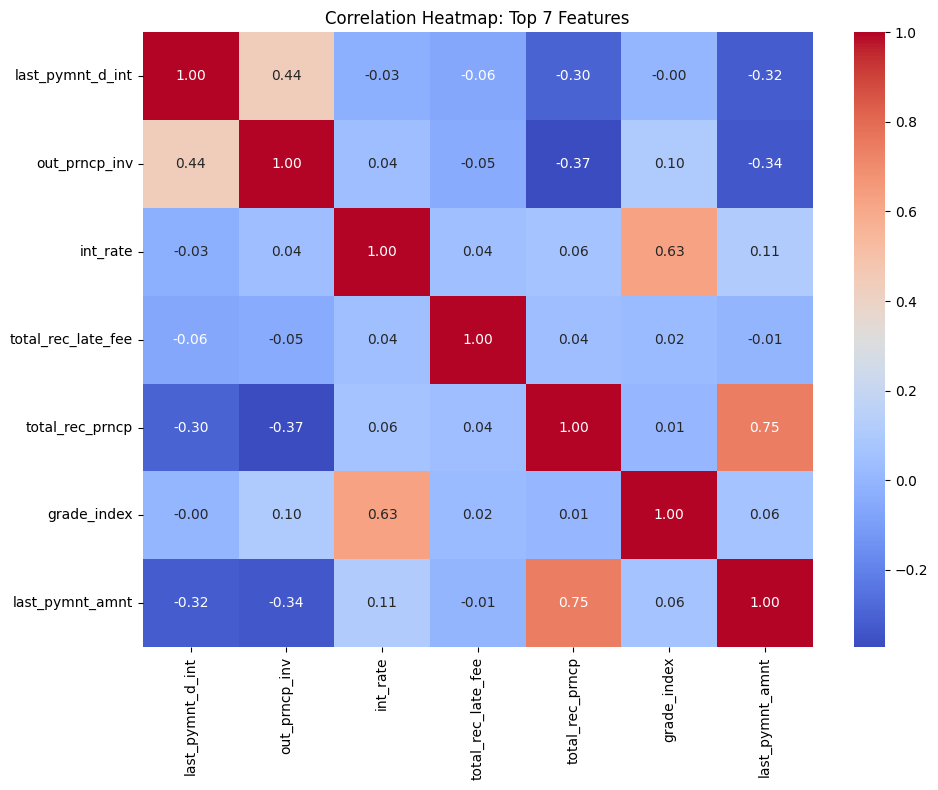

In [16]:
# Define the top 7 relevant features
top_features = [col_name for col_name, corr in sorted_corr[:7]]


# Sample and convert only selected columns
df_sample = train_df.select(top_features).sample(False, 0.1, seed=42).toPandas()


# Compute pairwise correlation for selected features
corr = df_sample.corr()


# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Top 7 Features')
plt.tight_layout()
plt.show()

Now we visualise the dataset to axamine the range as well as the distribution of features to decide wheter scaling or standardising is necessary.

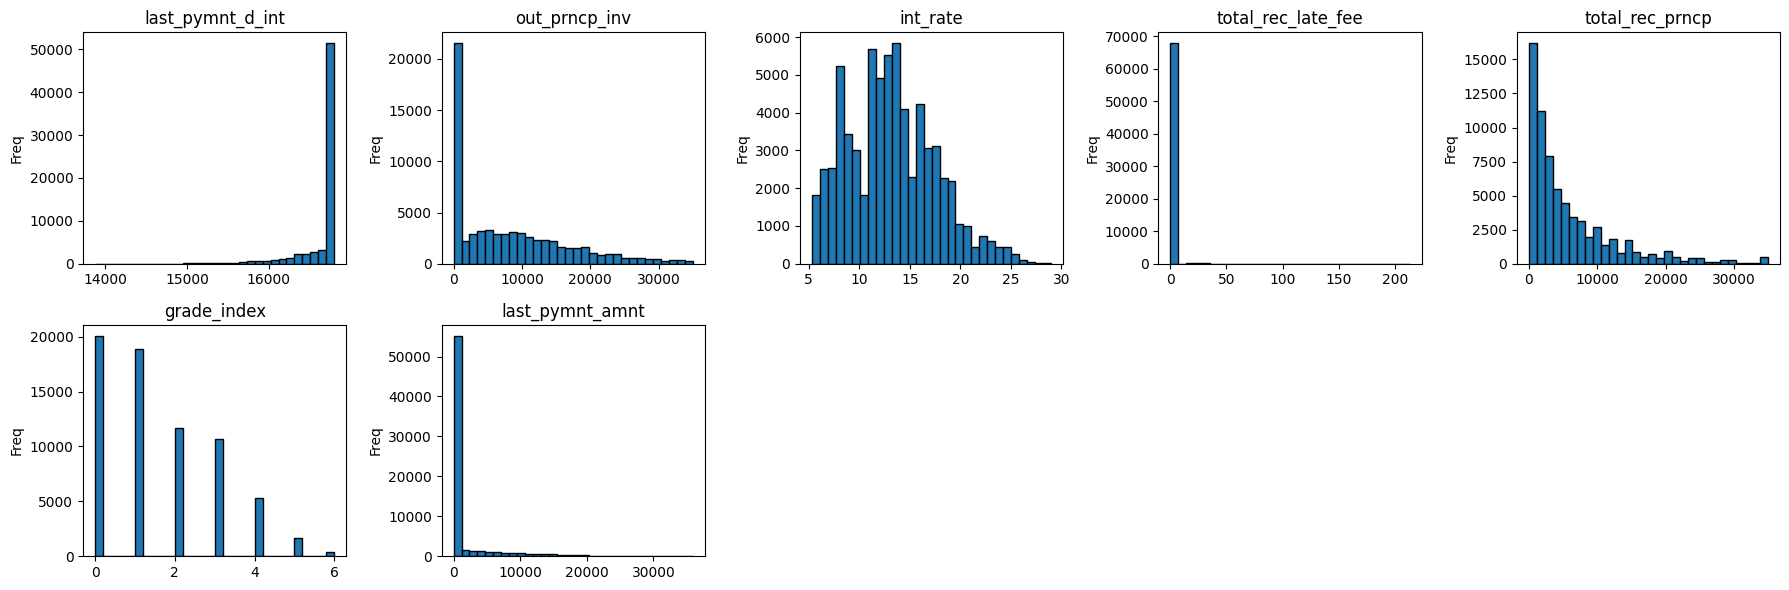

In [17]:
# Plot histograms
n_cols = 5
n_rows = int(len(top_features) / n_cols) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3))
axes = axes.flatten()
for i, col in enumerate(top_features):
    axes[i].hist(df_sample[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel("Freq")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

### Exploratory Data Analysis of Feature Distributions

The distribution of many numerical features seems to be Inverse Gaussian. If probabilistic modelling is required, this distribution is a strong candidate for any Bayesian model.

#### Numerical Features

Most numerical features such as `loan_amnt`, `annual_inc`, `tot_cur_bal`, `total_rev_hi_lim`, and `tot_coll_amt` show strong right-skewed distributions. These variables contain a large number of low values with a long tail of high values, indicating the presence of multiple outliers.

Some other features like `dti`, `installment`, and `int_rate` exhibit distributions that are closer to normal or mildly skewed.

- `revol_util` appears fairly uniformly distributed between 0 and 100.
- `default_ind` is highly imbalanced, with very few default cases (class 1).
- Features like `delinq_2yrs`, `inq_last_6mths`, and `pub_rec` are count variables, skewed towards zero.

**Conclusion**: While these features are skewed, no transformation is necessary for tree-based models (e.g., DecisionTree, RandomForest). However, One Hot Encoding will be considered for Naive Bayes

---

#### Categorical/Indexed Features

Features such as `term_index`, `grade_index`, `sub_grade_index`, `emp_length_index`, `home_ownership_index`, `verification_status_index`, `purpose_index`, `addr_state_index`, and `application_type_index` are all encoded categorical variables.

Observations:
- Many of these features have **imbalanced class distributions** (e.g., `term_index`, `application_type_index`), which may reduce their predictive power unless stratified.
- `sub_grade_index` and `addr_state_index` show a relatively broader spread across categories.
- `grade_index`, `emp_length_index`, and `purpose_index` show decreasing frequencies with higher category values, which might reflect socio-economic hierarchies.

**Conclusion**: These features can be used directly in tree-based models, or other flexible models without scaling or transformation. Their encoding is sufficient for model input, and advanced models like Naive Bayes will benefit from one-hot encoding or target encoding and standardisation.


---


## Training Data Preparation

### Assemble the Features Vector

In [18]:
features_col = [col for col in train_df.columns if col != "default_ind"]

# Assemble features separately on train and test, categorical featuers were indexed in previous parts
assembler = VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid = "skip")
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

### Compute Class Weights and Standardise

In this phase, we employed the class weight approach instead of using a subsample (with 20% of majority class) of the original dataset `train_df` for training.

From initial testing, the subsample approach enforces the wrong learning pattern, as the distribution of the target is no longer the same after taking a subsample. This shift of distribution assisted the tree-based models since they are not sensitive to scales, but influences the networks to learn the wrong pattern.

Therefore, we proceeded with weighting the classes to allow the networks to update their biases at every epoch without shifting the data's distribution.


In [19]:
nn_train_df = train_df.select('*')
nn_test_df = test_df.select('*')


# Ues class weights to attribute some bias towards the under-represented class
original_train_labels = np.array(nn_train_df.select("default_ind").rdd.map(lambda row: row[0]).collect())
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(original_train_labels),
                                     y=original_train_labels)


class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Computed class weights: {class_weight_dict}")

Computed class weights: {0: np.float64(0.5287084778455775), 1: np.float64(9.208229023661472)}


Since neural networks are more sensitive to scales, we standardised the assembled features vector in the next step. This procedure ensures training stability and reduce numerical errors.  

In [20]:
# Standardise the data due to scale sensitivity of neural networks
scaler = StandardScaler(inputCol="features",
                        outputCol="scaled_features",
                        withStd=True,
                        withMean=True)


model_scaler = scaler.fit(nn_train_df)
scaled_train_df = model_scaler.transform(nn_train_df)
scaled_test_df = model_scaler.transform(nn_test_df)

## Exporting Data

Finally, the processed data is exported as `.parquet` datasets to use in training. Initally, exporting the assembled `features` vector was not supported by CSV, which led to the `.parquet` change. The weights dictionary was also exported.

In [21]:
output_path = f"{config['processed_path']}processed_train_test_data"


# UDF to convert vector to array
vector_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Convert features to arrays before saving (distributed operation)
train_df_array = scaled_train_df.withColumn("features", vector_to_array("features"))
test_df_array = scaled_test_df.withColumn("features", vector_to_array("features"))

# Save to parquet (distributed write)
train_df_array.repartition(1).write.parquet(f"{output_path}/train", mode="overwrite")
test_df_array.repartition(1).write.parquet(f"{output_path}/test", mode="overwrite")


with open(f'{output_path}class_weight_dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in class_weight_dict.items():
       writer.writerow([key, value])